In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
from gnninterpreter import *

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

import torch
from torch import nn
import torch_geometric as pyg
from torchmetrics import F1Score

# Cyclicity

In [8]:
cyclicity = CyclicityDataset(seed=12345)
k_fold = 10
train_data = cyclicity[len(cyclicity)//k_fold:]
val_data = cyclicity[:len(cyclicity)//k_fold]
train_loader = pyg.loader.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = pyg.loader.DataLoader(val_data, batch_size=128, shuffle=False)

Extracting data/Cyclicity/raw/rome-graphml.tgz
Processing...


Loading graphs:   0%|          | 0/11534 [00:00<?, ?it/s]

Done!


In [9]:
cyclicity.describe()

{'mean_n': 52.76344180335058,
 'mean_m': 52.51504254012806,
 'std_n': 25.45414709419518,
 'std_m': 25.46061875996072}

# Train Model

In [12]:
kwargs = dict(node_features=len(cyclicity.NODE_CLS),
              edge_features=len(cyclicity.EDGE_CLS),
              num_classes=len(cyclicity.GRAPH_CLS),
              hidden_channels=32)
model = NNConvClassifier(**kwargs)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [13]:
def train():
    model.train()
    losses = []
    for batch in tqdm(train_loader, position=1, leave=False, disable=True):
        model.zero_grad()  # Clear gradients.
        out = model(batch)  # Perform a single forward pass.
        loss = criterion(out['logits'], batch.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def test(loader):
    f1 = F1Score(task="multiclass", num_classes=len(cyclicity.GRAPH_CLS), average=None)
    model.eval()
    for batch in tqdm(loader, position=1, leave=False, disable=True):
        f1(model(batch)['logits'], batch.y)
    return dict(zip(cyclicity.GRAPH_CLS.values(), f1.compute().tolist()))

@torch.no_grad()
def gt_score():
    batch = pyg.data.Batch.from_data_list([cyclicity.motifs[1]])
    neg, pos = model(batch).mean(dim=0).numpy()
    return neg, pos

In [22]:
for epoch in trange(16, position=0, leave=True, disable=True):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(val_loader)
    # neg, pos = gt_score()
    print(
        f'Epoch: {epoch:03d}, '
        f'Train Loss: {train_loss:.4f}, '
        f'Train Acc: {train_acc}, '
        f'Test Acc: {test_acc}, '
        # f'GT Pos Score: {pos:.4f}, '
        # f'GT Neg Score: {neg:.4f}, '
    )

Epoch: 000, Train Loss: 0.1210, Train Acc: {'red_cyclic': 0.9461339712142944, 'green_cyclic': 0.6990545988082886, 'acyclic': 0.8788838386535645}, Test Acc: {'red_cyclic': 0.9797297120094299, 'green_cyclic': 0.604651153087616, 'acyclic': 0.8553259372711182}, 
Epoch: 001, Train Loss: 0.3241, Train Acc: {'red_cyclic': 0.9555683732032776, 'green_cyclic': 0.9203611016273499, 'acyclic': 0.9400270581245422}, Test Acc: {'red_cyclic': 0.9797979593276978, 'green_cyclic': 0.9900000095367432, 'acyclic': 0.9834254384040833}, 
Epoch: 002, Train Loss: 0.1601, Train Acc: {'red_cyclic': 0.9627388119697571, 'green_cyclic': 0.9291675686836243, 'acyclic': 0.9505775570869446}, Test Acc: {'red_cyclic': 0.9917355179786682, 'green_cyclic': 0.9796609878540039, 'acyclic': 0.9843317866325378}, 
Epoch: 003, Train Loss: 0.1369, Train Acc: {'red_cyclic': 0.9595111012458801, 'green_cyclic': 0.9216628074645996, 'acyclic': 0.9448518753051758}, Test Acc: {'red_cyclic': 0.9917355179786682, 'green_cyclic': 0.949913620948

In [23]:
# torch.save(model.state_dict(), 'cyclicity_nnconv.pt')
model.load_state_dict(torch.load('cyclicity_nnconv.pt'))

<All keys matched successfully>

In [24]:
test(train_loader)

{'red_cyclic': 0.9601525068283081,
 'green_cyclic': 0.947325587272644,
 'acyclic': 0.9557915329933167}

In [25]:
test(val_loader)

{'red_cyclic': 0.9933554530143738,
 'green_cyclic': 0.9865771532058716,
 'acyclic': 0.9889094233512878}

# Generate Average Embedding

In [26]:
embeds = [[] for _ in range(len(cyclicity.GRAPH_CLS))]
with torch.no_grad():
    for data in tqdm(cyclicity):
        embeds[data.y.item()].append(model.eval()(pyg.data.Batch.from_data_list([data]))["embeds"].numpy())
mean_embeds = [torch.tensor(np.concatenate(e).mean(axis=0)) for e in embeds]

  0%|          | 0/11401 [00:00<?, ?it/s]

In [27]:
trainer = {}
sampler = {}

# 1

In [59]:
classes = 1
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_edge_cls=len(cyclicity.EDGE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=False,
                                    learn_edge_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=1),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    # NormPenalty(lambda: s.eta, order=1, weight=0), # L1 penalty on eta
    # NormPenalty(lambda: s.eta, order=2, weight=0), # L2 penalty on eta
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=100), # Budget penalty on theta, encourage sparsity
    # CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=1), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                  discriminator=model,
                  criterion=criterion,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  dataset=cyclicity,
                  k_samples=16)

In [60]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9


In [61]:
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [62]:
trainer[1].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

n=11 m=18
logits=[-216.79331970214844, 558.6318359375, -311.3712463378906]
probs=[0.0, 1.0, 0.0]


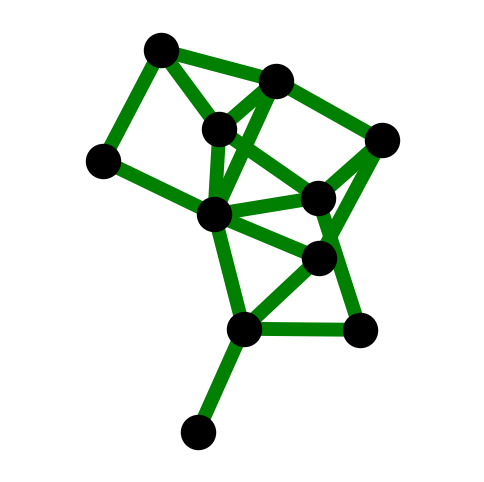

In [63]:
G = trainer[classes].evaluate(threshold=0.5, show=True)
plt.show()

# 2

In [92]:
classes = 2
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_edge_cls=len(cyclicity.EDGE_CLS),
                                    temperature=0.1,
                                    learn_node_feat=False,
                                    learn_edge_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=0), mode="maximize", weight=0.5),
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=2), mode="maximize", weight=-0.5),
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=3), mode="maximize", weight=-0.5),
        # dict(key="logits", criterion=CrossEntropyBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=MeanSquareBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=DynamicBalancingCriterion(classes=classes), weight=5),
        # dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes[0]]), weight=10),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=5),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    # NormPenalty(lambda: s.eta, order=1, weight=0), # L1 penalty on eta
    # NormPenalty(lambda: s.eta, order=2, weight=0), # L2 penalty on eta
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=25), # Budget penalty on theta, encourage sparsity
    # CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=15), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=cyclicity,
                           k_samples=16)

In [93]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9


In [94]:
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [95]:
trainer[2].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=13 m=12
logits=[-15.828670501708984, -7.78698205947876, 3.6513009071350098]
probs=[3.4669809245713168e-09, 1.0774872862384655e-05, 0.9999892711639404]


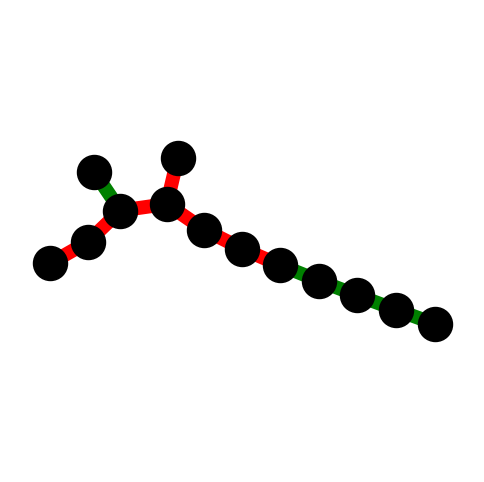

In [96]:
trainer[2].evaluate(threshold=0.5, show=True)

n=15 m=14
logits=[-8.079935073852539, -6.416947364807129, 3.0488319396972656]
probs=[1.4682427718071267e-05, 7.745050243102014e-05, 0.9999078512191772]


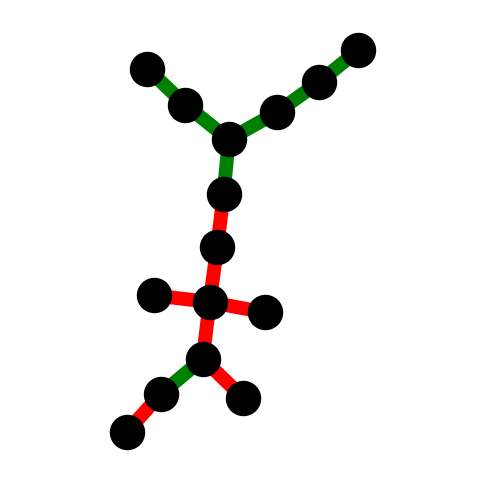

In [98]:
trainer[2].evaluate(bernoulli=True, show=True)

# 0

In [129]:
classes = 0
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_edge_cls=len(cyclicity.EDGE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=False,
                                    learn_edge_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=0), mode="maximize", weight=0.5),
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=2), mode="maximize", weight=-0.5),
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=3), mode="maximize", weight=-0.5),
        # dict(key="logits", criterion=CrossEntropyBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=MeanSquareBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=DynamicBalancingCriterion(classes=classes), weight=5),
        # dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes[0]]), weight=10),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=1),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    NormPenalty(lambda: s.eta, order=1, weight=1), # L1 penalty on eta
    NormPenalty(lambda: s.eta, order=2, weight=1), # L2 penalty on eta
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=50), # Budget penalty on theta, encourage sparsity
    # CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=1), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=cyclicity,
                           k_samples=16)

In [130]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9
    
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [131]:
trainer[0].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

n=17 m=28
logits=[587.2236938476562, -609.8198852539062, -626.7744750976562]
probs=[1.0, 0.0, 0.0]


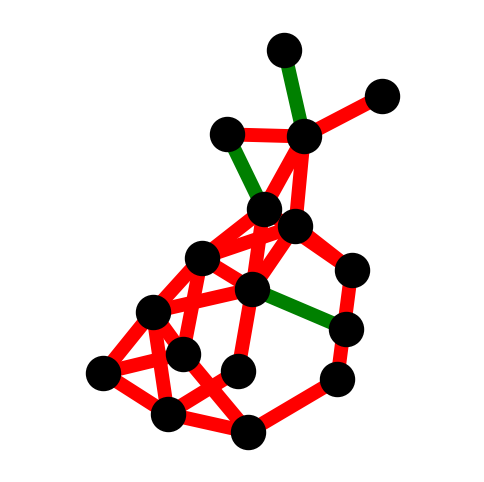

In [132]:
trainer[0].evaluate(threshold=0.5, show=True)

n=17 m=28
logits=[587.2236938476562, -609.8198852539062, -626.7744750976562]
probs=[1.0, 0.0, 0.0]


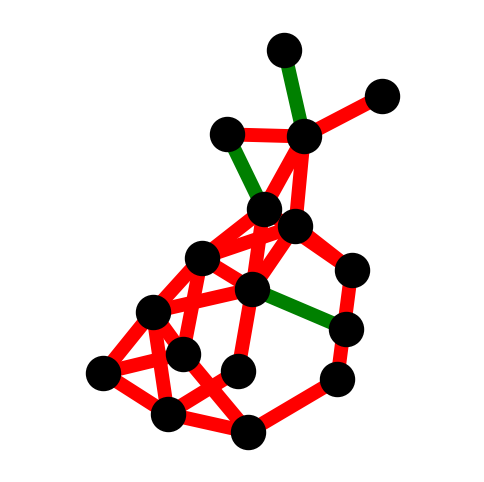

In [133]:
trainer[0].evaluate(bernoulli=True, show=True)